In [9]:
import os
import random
import sys
import cv2
import tqdm
import json
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from math import copysign, log10

In [8]:
from tensorflow.keras import models, layers
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121


import tensorflow as tf
import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds


# Data

In [10]:
# Database
images_dir = "/kaggle/input/vindr-mammo-dataset/Processed_Images/Processed_Images"
metadata_dir = "/kaggle/input/vindr-mammo-dataset/updated_metadata.csv"

In [11]:
annotations = pd.read_csv(metadata_dir)
annotations.finding_categories = annotations.finding_categories.replace("'", '"', regex=True).apply(json.loads)

In [12]:
categories = list(set([a for b in annotations.finding_categories for a in b]))
print(len(categories))

annotations["bx"] = (annotations["xmax"] + annotations["xmin"]) / 2
annotations["by"] = (annotations["ymax"] + annotations["ymin"]) / 2
annotations["bh"] = annotations["ymax"] - annotations["ymin"]
annotations["bw"] = annotations["xmax"] - annotations["xmin"]



11


In [13]:
print((categories))

['Global Asymmetry', 'Suspicious Calcification', 'Skin Retraction', 'Architectural Distortion', 'Nipple Retraction', 'Focal Asymmetry', 'Asymmetry', 'Skin Thickening', 'Suspicious Lymph Node', 'No Finding', 'Mass']


In [14]:
"""
#NO ES NECESARIO EJECUTAR ESTA CELDA, fue una prueba que estaba haciendo para ver como proceder con el resize


min_height, min_width = float('inf'), float('inf')

for path in annotations["directory_path"]:
    im = cv2.imread(f'/kaggle/input/vindr-mammo-dataset/Processed_Images/{path}', cv2.IMREAD_GRAYSCALE)
    h, w = im.shape[:2]
    min_height = min(min_height, h)
    min_width = min(min_width, w)

print(f"Lowest image dimensions: {min_width}x{min_height}")
"""

'\n#NO ES NECESARIO EJECUTAR ESTA CELDA, fue una prueba que estaba haciendo para ver como proceder con el resize\n\n\nmin_height, min_width = float(\'inf\'), float(\'inf\')\n\nfor path in annotations["directory_path"]:\n    im = cv2.imread(f\'/kaggle/input/vindr-mammo-dataset/Processed_Images/{path}\', cv2.IMREAD_GRAYSCALE)\n    h, w = im.shape[:2]\n    min_height = min(min_height, h)\n    min_width = min(min_width, w)\n\nprint(f"Lowest image dimensions: {min_width}x{min_height}")\n'

# Dataset adjustments

In [15]:
len_df = annotations.shape[0]
resized_base_path = "/kaggle/working/"

os.makedirs(resized_base_path, exist_ok=True)

for i in range(len_df):
    row = annotations.iloc[i]
    
    img_path = f'/kaggle/input/vindr-mammo-dataset/Processed_Images/{row.directory_path}'
    
    im = cv2.imread(img_path)
    
    if im is None:
        print(f"Warning: Image at {img_path} could not be loaded.")
        continue 
    
    # Obtener dimensiones originales de la imagen
    original_height, original_width = im.shape[:2]

    # Dimensiones objetivo
    target_width, target_height = 320, 1280 #Para YOLO probé con esta escala, toca ver si podemos mejorar esto

    # Calcular factores de escala
    scale_x = target_width / original_width
    scale_y = target_height / original_height

    # Redimensionar la imagen
    im_resized = cv2.resize(im, (target_width, target_height))

    # Aplicar la transformación de escala a las coordenadas de la bounding box
    annotations.at[i, "xmin"] = row.xmin * scale_x
    annotations.at[i, "xmax"] = row.xmax * scale_x
    annotations.at[i, "ymin"] = row.ymin * scale_y
    annotations.at[i, "ymax"] = row.ymax * scale_y

    # Recalcular las bounding boxes después del resize
    annotations.at[i, "bx"] = (annotations.at[i, "xmax"] + annotations.at[i, "xmin"]) / 2
    annotations.at[i, "by"] = (annotations.at[i, "ymax"] + annotations.at[i, "ymin"]) / 2
    annotations.at[i, "bh"] = annotations.at[i, "ymax"] - annotations.at[i, "ymin"]
    annotations.at[i, "bw"] = annotations.at[i, "xmax"] - annotations.at[i, "xmin"]

    # Guardar la imagen redimensionada
    new_img_path = f"{resized_base_path}/{row.directory_path}"
    
    os.makedirs(os.path.dirname(new_img_path), exist_ok=True)
    
    cv2.imwrite(new_img_path, im_resized)
    
    # Actualizar la ruta de la imagen en el DataFrame
    annotations.at[i, "directory_path"] = new_img_path

annotations

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,...,xmin,ymin,xmax,ymax,split,directory_path,bx,by,bh,bw
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,[Mass],...,810.370716,1079.639171,854.358703,1155.148563,training,/kaggle/working//Processed_Images/48575a27b7c9...,832.364709,1117.393867,75.509392,43.987987
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,[Mass],...,792.258898,493.775119,830.473045,538.921409,training,/kaggle/working//Processed_Images/48575a27b7c9...,811.365972,516.348264,45.146290,38.214147
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,[Global Asymmetry],...,908.265975,744.333406,1077.734472,1393.745171,training,/kaggle/working//Processed_Images/75e8e4893328...,993.000224,1069.039288,649.411765,169.468497
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,[Global Asymmetry],...,619.788311,572.269811,821.331222,869.642885,training,/kaggle/working//Processed_Images/75e8e4893328...,720.559767,720.956348,297.373074,201.542911
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,[Architectural Distortion],...,674.234739,800.726500,741.400567,873.883843,training,/kaggle/working//Processed_Images/c3487424fee1...,707.817653,837.305172,73.157343,67.165828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20481,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,[No Finding],...,NaN,NaN,NaN,NaN,training,/kaggle/working//Processed_Images/f2093a752e6b...,NaN,NaN,NaN,NaN
20482,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,[No Finding],...,NaN,NaN,NaN,NaN,training,/kaggle/working//Processed_Images/b3c8969cd2ac...,NaN,NaN,NaN,NaN
20483,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,[No Finding],...,NaN,NaN,NaN,NaN,training,/kaggle/working//Processed_Images/b3c8969cd2ac...,NaN,NaN,NaN,NaN
20484,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,[No Finding],...,NaN,NaN,NaN,NaN,training,/kaggle/working//Processed_Images/b3c8969cd2ac...,NaN,NaN,NaN,NaN


In [16]:
im_resized.shape

(1280, 320, 3)

# Hu Moments
350x1391

In [17]:

for j in range(7):
    annotations[f'HuMoment_{j}'] = np.nan 

for i in range(len_df):
    row = annotations.iloc[i]
    im = cv2.imread(f'{row.directory_path}', cv2.IMREAD_GRAYSCALE)
    _, im = cv2.threshold(im, 128, 255, cv2.THRESH_TRUNC) # Trunc porque la radiografia NO son solo #00000 y #FFFFF
    
    #  Moments 
    moments = cv2.moments(im) 
    
    #  Hu Moments 
    huMoments = cv2.HuMoments(moments)

   
    for j in range(7):
        if huMoments[j, 0] != 0:
            huMoments[j, 0] = -1 * copysign(1.0, huMoments[j, 0]) * log10(abs(huMoments[j, 0]))
        else:
            huMoments[j, 0] = 0 
    
    
    for j in range(7):
        annotations.at[i, f'HuMoment_{j}'] = huMoments[j, 0]

(1280, 320)
(1280, 320)
(1280, 320)
(1280, 320)
(1280, 320)
(1280, 320)
(1280, 320)
(1280, 320)
(1280, 320)
(1280, 320)


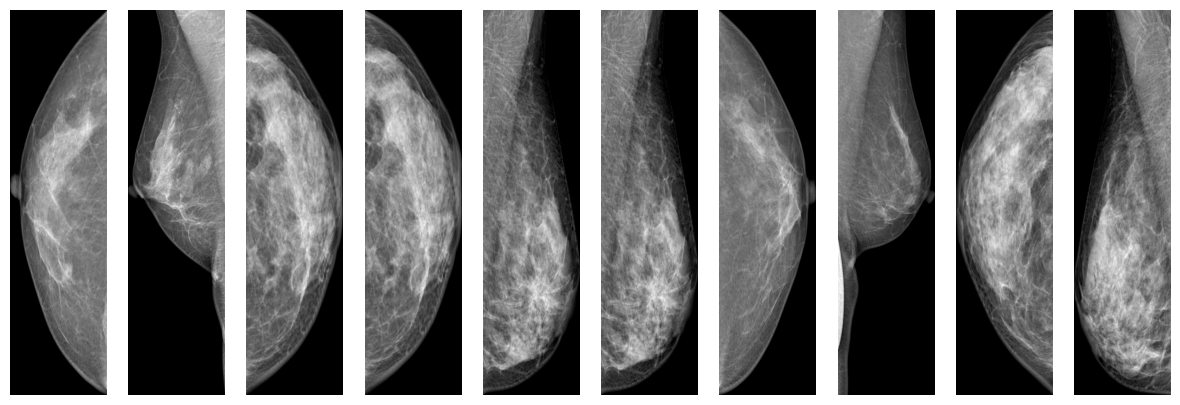

In [18]:
#TEST

def show_images_for_study_ids(df, study_id1, study_id2, base_path='/kaggle/working/Processed_Images/'):
    # Filter DataFrame for the given study IDs
    filtered_df = df[df['study_id'].isin([study_id1, study_id2])]

    if filtered_df.empty:
        print("No images found for the given study IDs.")
        return

    # Get image paths
    image_paths = filtered_df['directory_path'].tolist()

    # Display images
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    
    if len(image_paths) == 1:
        axes = [axes]  # Ensure iterable when only one image exists
    
    for ax, img_path in zip(axes, image_paths):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            ax.set_title("Image not found")
            ax.axis("off")
            continue
        ax.imshow(img, cmap='gray')
        ax.axis("off")
        print(img.shape)

    plt.show()

# Example usage
study_id1 = "48575a27b7c992427041a82fa750d3fa"
study_id2 = "57674c2def92287668ed5bc51092fbef"
#study_id1 = "48575a27b7c992427041a82fa750d3fa"
#study_id2 = "eb4958718053ebd1ceda6c4a91179f53"
show_images_for_study_ids(annotations, study_id1, study_id2)

In [19]:
#TEST

def get_hu_moments_for_study_ids(df, study_id1, study_id2):
    """Extracts Hu Moments for given study IDs and stores them in two separate arrays."""
    # Filter DataFrame for the given study IDs
    filtered_df = df[df['study_id'].isin([study_id1, study_id2])]

    if filtered_df.empty:
        print("No data found for the given study IDs.")
        return None, None

    # Extract Hu Moments columns
    hu_columns = ['HuMoment_0', 'HuMoment_1', 'HuMoment_2', 'HuMoment_3', 
                  'HuMoment_4', 'HuMoment_5', 'HuMoment_6']

    # Separate Hu Moments into two arrays
    hu_moments_1 = filtered_df[filtered_df['study_id'] == study_id1][hu_columns].to_numpy()
    hu_moments_2 = filtered_df[filtered_df['study_id'] == study_id2][hu_columns].to_numpy()

    return hu_moments_1, hu_moments_2

# Example usage
study_id1 = "48575a27b7c992427041a82fa750d3fa"
study_id2 = "57674c2def92287668ed5bc51092fbef"

hu_array_1, hu_array_2 = get_hu_moments_for_study_ids(annotations, study_id1, study_id2)

# Print or use the extracted arrays
print("Hu Moments for Study ID 1:")
print(hu_array_1)

print("\nHu Moments for Study ID 2:")
print(hu_array_2)


Hu Moments for Study ID 1:
[[  2.46990048   5.05888915   8.40885425   9.3928459  -18.39944558
  -11.98054201  18.50066696]
 [  2.48654073   5.13625597   8.41781894   9.09808516  17.96654633
   12.36288653  18.05563158]
 [  2.45809133   5.03526295   8.35828056   9.31392872 -18.44423852
  -11.98059669 -18.21482619]
 [  2.44602079   5.03664132   7.91508973   8.11463828  16.12956181
   10.6949848  -17.91053857]]

Hu Moments for Study ID 2:
[[  2.52685953   5.20048375   8.51908737   9.41401657 -19.28072545
  -12.32877783 -18.38403513]
 [  2.52685953   5.20048375   8.51908737   9.41401657 -19.28072545
  -12.32877783 -18.38403513]
 [  2.37778078   4.84109259   7.97632961   8.13201073  16.1864254
   10.56472754  17.66053157]
 [  2.37778078   4.84109259   7.97632961   8.13201073  16.1864254
   10.56472754  17.66053157]
 [  2.51451852   5.17267365   8.41884496   9.25346003  18.84456088
  -12.3974091   18.09643054]
 [  2.36307541   4.80626295   7.81893729   7.93934673  15.81852908
   10.34690079 

# YOLOOOOOO

In [20]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 17.9 MB/s eta 0:00:0000:01


In [21]:
# Definir las clases en orden
CLASSES = [
    "Nipple Retraction", "Global Asymmetry", "No Finding", "Asymmetry",
    "Skin Retraction", "Suspicious Calcification", "Focal Asymmetry",
    "Skin Thickening", "Mass", "Architectural Distortion", "Suspicious Lymph Node"
]

# Crear un diccionario para asignar índices a cada categoría
class_to_idx = {cls: i for i, cls in enumerate(CLASSES)}


In [22]:
import ast  # Para convertir string de listas a listas reales

def get_class_index(category_str):
    """
    Extrae la clase y la convierte en su índice numérico.
    """
    if isinstance(category_str, list):  # Si ya es una lista, la usamos directamente
        category_list = category_str
    else:
        try:
            category_list = ast.literal_eval(category_str)  # Convertir string a lista
        except (ValueError, SyntaxError):
            return -1  # Si hay un error, devolver -1
    
    if category_list:  # Si la lista no está vacía
        return class_to_idx.get(category_list[0], -1)  # Retorna índice de la clase
    return -1  # Si no tiene categoría

# Aplicar la conversión
annotations["class_id"] = annotations["finding_categories"].apply(get_class_index)


In [23]:
yolo_labels_path = "/kaggle/working/yolo_labels/"
os.makedirs(yolo_labels_path, exist_ok=True)

for i, row in annotations.iterrows():
    img_path = f'{row.directory_path}'
    
    if row.class_id == -1:
        continue
    
    # Normalizar coordenadas para YOLO (Algo raro en google, pruebo primero con las que ya saque como dijo
    # el profe eduardo)

    x_center = row.bx
    y_center = row.by
    bbox_width = row.bw
    bbox_height = row.bh
    
    #x_center = row.bx / row.width
    #y_center = row.by / row.height
    #bbox_width = row.bw / row.width
    #bbox_height = row.bh / row.height

    # Crear archivo de anotaciones YOLO
    yolo_label_path = os.path.join(yolo_labels_path, f"{row.image_id}.txt")
    with open(yolo_label_path, "w") as f:
        f.write(f"{row.class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")

In [24]:
import shutil

base_yolo_path = "/kaggle/working/dataset/"

for i, row in annotations.iterrows():
    split_folder = "train" if row.split == "training" else "val"
    
    # Mover imagen a la carpeta de imágenes YOLO
    img_dest_path = os.path.join(base_yolo_path, "images", split_folder, f"{row.image_id}.jpg")
    os.makedirs(os.path.dirname(img_dest_path), exist_ok=True)
    shutil.copy(row.directory_path, img_dest_path)
    
    # Mover anotaciones a la carpeta de labels YOLO
    label_src_path = os.path.join(yolo_labels_path, f"{row.image_id}.txt")
    label_dest_path = os.path.join(base_yolo_path, "labels", split_folder, f"{row.image_id}.txt")
    os.makedirs(os.path.dirname(label_dest_path), exist_ok=True)
    shutil.copy(label_src_path, label_dest_path)

In [25]:
import yaml

# Definir la configuración para YOLO
yolo_config = {
    "train": "/kaggle/working/dataset/images/train",  # Ruta a los datos de entrenamiento
    "val": "/kaggle/working/dataset/images/val",      # Ruta a los datos de validación
    "nc": 11,  # Número de clases (según las 11 categorías que mencionaste)
    "names": [
        "Nipple Retraction", "Global Asymmetry", "No Finding", "Asymmetry", "Skin Retraction",
        "Suspicious Calcification", "Focal Asymmetry", "Skin Thickening", "Mass",
        "Architectural Distortion", "Suspicious Lymph Node"
    ]
}

# Ruta donde se guardará el archivo
yaml_path = "/kaggle/working/dataset/data.yaml"

# Guardar el archivo YAML
with open(yaml_path, "w") as file:
    yaml.dump(yolo_config, file, default_flow_style=False)

print(f"Archivo YAML guardado en: {yaml_path}")

Archivo YAML guardado en: /kaggle/working/dataset/data.yaml


In [26]:
import os
print("Ruta del archivo data.yaml:", os.path.exists("/kaggle/working/dataset/data.yaml"))

Ruta del archivo data.yaml: True


In [27]:
import os

dataset_path = "/kaggle/working/dataset/"
expected_folders = ["images/train", "images/val", "labels/train", "labels/val"]

for folder in expected_folders:
    full_path = os.path.join(dataset_path, folder)
    print(f"{full_path}: {'✅ Existe' if os.path.exists(full_path) else '❌ No existe'}")

/kaggle/working/dataset/images/train: ✅ Existe
/kaggle/working/dataset/images/val: ✅ Existe
/kaggle/working/dataset/labels/train: ✅ Existe
/kaggle/working/dataset/labels/val: ✅ Existe


## Modelo

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt") # No se si este es el correcto, en este link estan todos los modelos 
                            #https://docs.ultralytics.com/models/yolo11/#supported-tasks-and-modes
model.train(data="/kaggle/working/dataset/data.yaml", epochs=5, imgsz=300) #no se si ese imgsz afecte el resultado por
                                                                            #el resize automatico que hace

In [ ]:
results = model("/kaggle/working/dataset/images/val/ejemplo.jpg")
results.show()
